# Блок №6

# Задание 1
___
Применим знания на практике: с помощью `pandahouse` попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python!

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

+ **ldn_listings** – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах;

Для начала, проверим правильность подключения к ClickHouse через `pandahouse`, отправив простой запрос: выведите количество строк в таблице `ldn_listings`.

In [48]:
# Установить библиотеку можно, запустив такую команду в ячейке Jupyter Notebook:
# pip install pandahouse

# Импорт библиотеки и credentials для подключения к базе default:

import pandahouse as ph
import pandas as pd
import numpy as np

connection = {'database':'default',
              'host': 'http://clickhouse.beslan.pro:8080',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [7]:
# Запрос на количество строк задаем в переменной:

query = """
    SELECT 
        COUNT(*)
    FROM 
        ldn_listings
    """

# И запустим запрос:

ph.read_clickhouse(query, connection=connection)

,count()
0,85207


# Задание 2
___
Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

+ `price` – цена за ночь
+ `room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию `id`.

Пример результирующей таблицы:

| room_type       | price      |
|-----------------|------------|
| Private room    |         65 | 
| Entire home/apt |        100 | 


Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [8]:
# Выгрузим необходимые данные следующим запросом: 

query = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM
        ldn_listings
    ORDER BY
            id ASC
    limit 1000
'''

df = ph.read_clickhouse(query, connection=connection)

# Далее необходимо посчитать 75 процентиль для цены по типу сдаваемого жилья:
df = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()

# Нас интересует private room
df[df['room_type'] == 'Private room']

,room_type,price
2,Private room,70.0


# Задание 3
___
К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (`review_scores_rating`). В запросе необходимо будет отфильтровать пустые значения `review_scores_rating` и сконвертировать эту колонку в тип `float32`.

Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Исходная таблица должна выглядеть так:

| room_type       | price      |review_scores_rating|
|-----------------|------------|--------------------|
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу `float`)

2) используйте `sns.scatterplot`, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр `hue`)

Среди представленных ниже графиков выберите корректный:
![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7851/image.png)

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

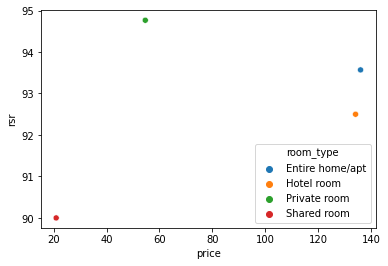

In [12]:
# Для начала необходимо выгрузить запросом и обработать данные:

query = '''
    SELECT 
        room_type,
        toFloat32OrNull(review_scores_rating) as rsr,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM
        ldn_listings
    WHERE
        rsr is not null
    ORDER BY
        id
    LIMIT 1000
'''

df = ph.read_clickhouse(query, connection=connection)
df = df.groupby(['room_type'], as_index=False) \
     .agg({'price': 'mean',
           'rsr': 'mean'})

# Затем строим график, передавая в параметры необходимые значения:
sns.scatterplot(data=df, x ='price', y='rsr', hue='room_type');

# Правильный ответ: 2

# Задание 4
___
Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (`experiences_offered != 'none'`). Для каждого уникального пользователя выгрузите только две колонки:

+ `host_id` – идентификатор хозяина (уникальный)
+ `host_verifications` – какими способами хост подтвердил свой профиль

Затем обработайте столбец `host_verifications`:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
> "['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы `explode` и `value_counts`, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [29]:
# Первоначально выгружаем данные при помощи запроса:

q = """
    SELECT
        DISTINCT host_id,
        host_verifications
    FROM
        ldn_listings
    WHERE
        experiences_offered != 'none'
"""

df = ph.read_clickhouse(q, connection=connection)

In [30]:
df.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [31]:
# Далее обрабатываем его с помощью pandas:
df = df \
    .host_verifications \
    .apply(lambda x: x.strip('[]').replace("'", '').split(', ')) \
    .explode() \
    .value_counts()

In [32]:
df

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [33]:
df.loc['google']

34

Правильный ответ: 34

# Задание 5
___
Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите e`xperiences_count`.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.


| neighbourhood_cleansed | experiences_offered | experiences_count |
|------------------------|---------------------|-------------------|
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |

Отсортируйте данные по убыванию `experiences_count` и выгрузите первые 100 строк. Затем преобразуйте данные с помощью `pivot`, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью `sns.heatmap()` c палитрой `cmap=sns.cubehelix_palette(as_cmap=True)`. 

Какой график получился?
![](https://storage.yandexcloud.net/klms-public/production/learning-content/28/373/2884/8875/35066/image2.png)

In [35]:
# Для начала подготавливаем данные с количеством впечатлений по району и виду впечатления:

q = """
    SELECT  
        neighbourhood_cleansed,
        experiences_offered,
        COUNT(*) AS experiences_count
    FROM 
        ldn_listings
    WHERE
        experiences_offered != 'none'
    GROUP BY
        neighbourhood_cleansed,
        experiences_offered
    ORDER BY
        experiences_count DESC
    LIMIT 100
"""

experiences = ph.read_clickhouse(q, connection=connection)

In [37]:
experiences.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


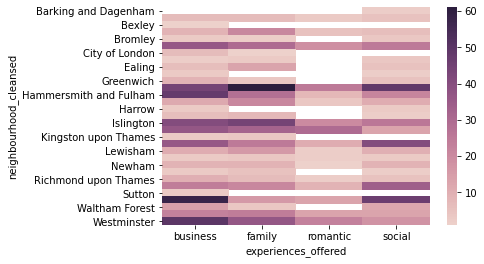

In [39]:
# Далее составляем pivot таблицу и строим график:

sns.heatmap(experiences.pivot(index= 'neighbourhood_cleansed', \
 columns='experiences_offered', values = 'experiences_count'), \
               cmap=sns.cubehelix_palette(as_cmap=True));

Правильный ответ: 1

# Задание 6
___
Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

+ `room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
+ `price` – цена за ночь 
+ `experiences_offered` – вид доступного впечатления (оставить не 'none')

Пример части результирующей таблицы:

| room_type       | price_corr |
|-----------------|------------|
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |

Далее постройте два графика, используя `distplot` из библиотеки `seaborn`:

+ На первом отобразите исходные распределения цен для каждого типа жилья
+ На втором – логарифмированные значения (np.log())

Среди представленных графиков выберите два соответствующих.
![](https://ucarecdn.com/711324e7-da8f-4d06-af7c-31eb0620cf6f/)

In [41]:
# C помощью запроса выгружаем информацию о стоимости жилья различного типа:

query = '''
    SELECT
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
        room_type
    FROM
        ldn_listings
    WHERE
        experiences_offered != 'none'
'''

df = ph.read_clickhouse(query, connection=connection)

In [42]:
df.head()

,price_corr,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,150.0,Private room
3,45.0,Private room
4,25.0,Private room


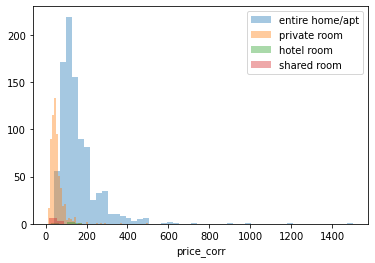

In [46]:
# Графики строим с помощью seaborn:

sns.distplot((df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot((df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
sns.distplot((df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot((df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

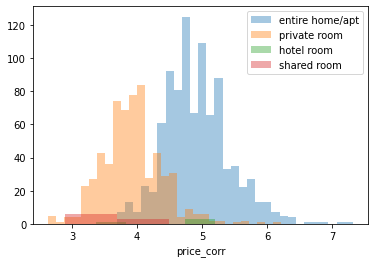

In [49]:
# Для построения логарифмированных значений воспользуемся np.log():

sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot(np.log(df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

Праильный ответ 3,6

# Задание 7
___
Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

+ `room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
+ `price` – цена за ночь
+ `first_review` – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.

Пример результирующей таблицы:

| room_type       | price_corr |first_review|
|-----------------|------------|------------|
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |

Используя библиотеку `seaborn` и функцию `lineplot`, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр '`hue`') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:

| room_type       | avg_price  | year       |
|-----------------|------------|------------|
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |

Среди представленных ниже графиков выберите корректный:
![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7855/image.png)

In [51]:
# Выгружаем необходимые данные с помощью запроса:

query = '''
    SELECT 
            room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
            first_review
    FROM
            ldn_listings
    WHERE 
        first_review > '2010-01-01'
    LIMIT 1000
'''

df = ph.read_clickhouse(query, connection=connection)

In [52]:
df.head()

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [53]:
# C помощью lambda - выражения и функции apply() получаем значение года:
df['year'] = df.first_review.apply(lambda x: x[:4])

In [54]:
df.head()

,room_type,price_corr,first_review,year
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010


In [56]:
# Рассчитываем среднюю стоимость в зависимости от года и типа жилья.
df = df.groupby(['year', 'room_type'], as_index=False) \
    .agg({'price_corr': 'mean'})

In [58]:
df.head()

,year,room_type,price_corr
0,2010,Entire home/apt,103.500000
1,2010,Hotel room,88.000000
2,2010,Private room,56.428570
3,2011,Entire home/apt,128.792450
4,2011,Private room,52.607143


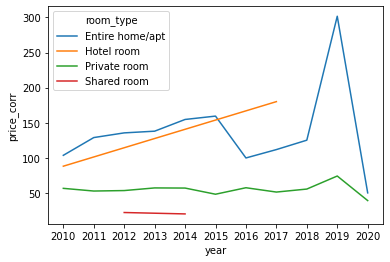

In [60]:
# Строим график:
sns.lineplot(data=df, hue='room_type', x = 'year', y='price_corr');

Правильный ответ: 1